In [1]:
import numpy as np
import pandas as pd
from glob import glob
import scipy.stats as sps
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import permutations
from matplotlib.font_manager import FontProperties
from tqdm.notebook import tqdm
import time

KeyboardInterrupt: 

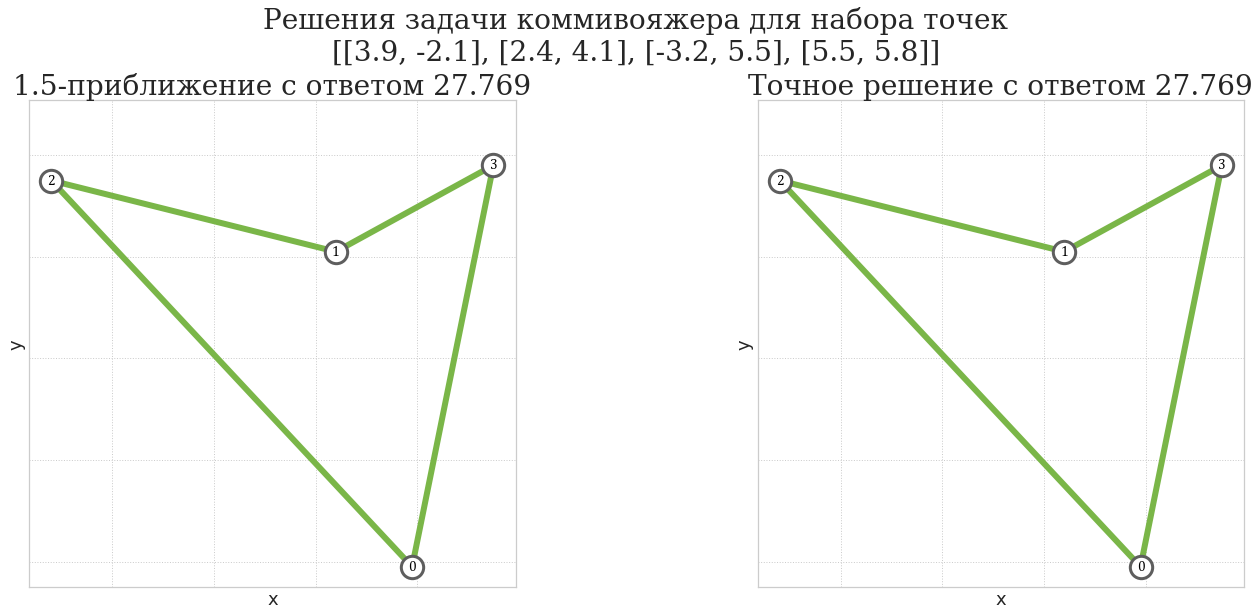

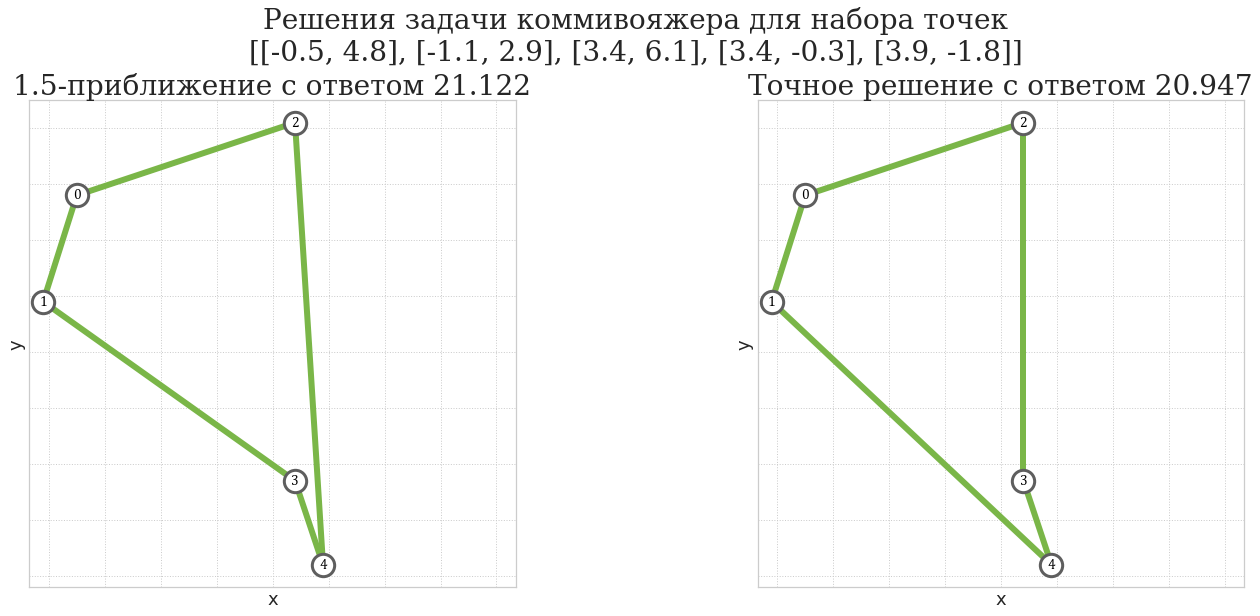

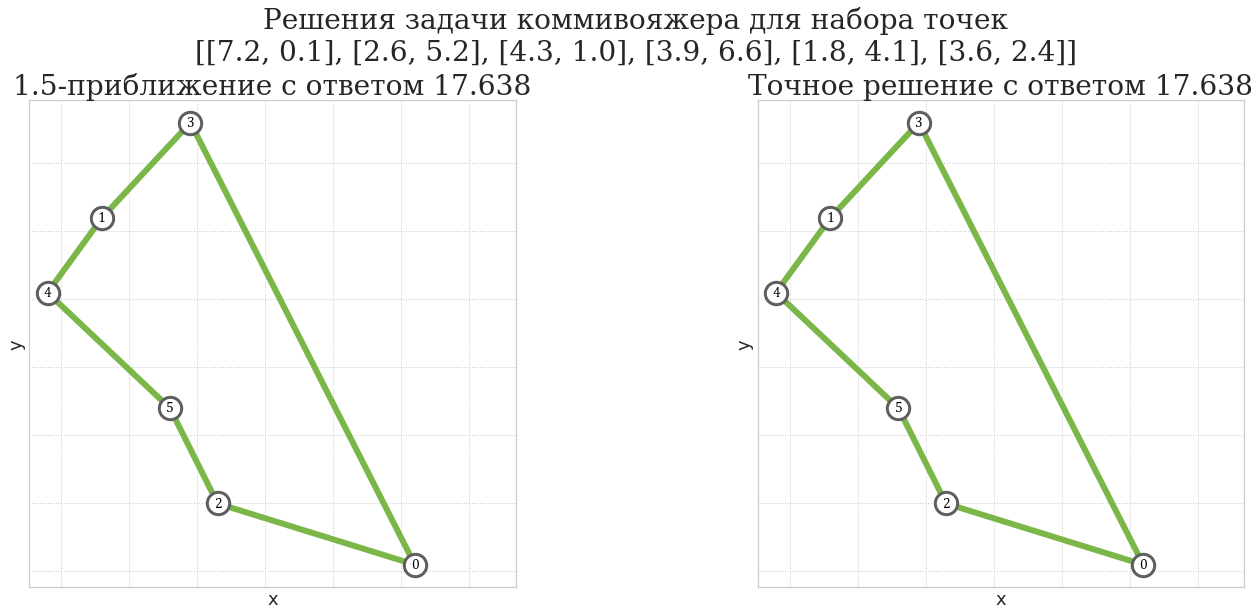

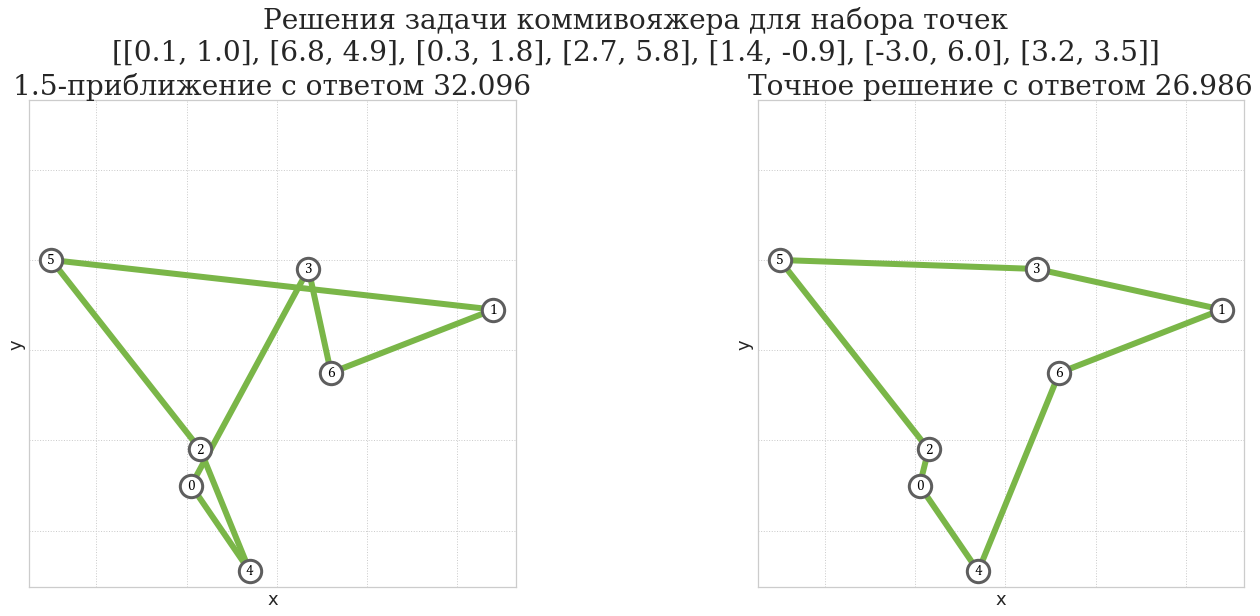

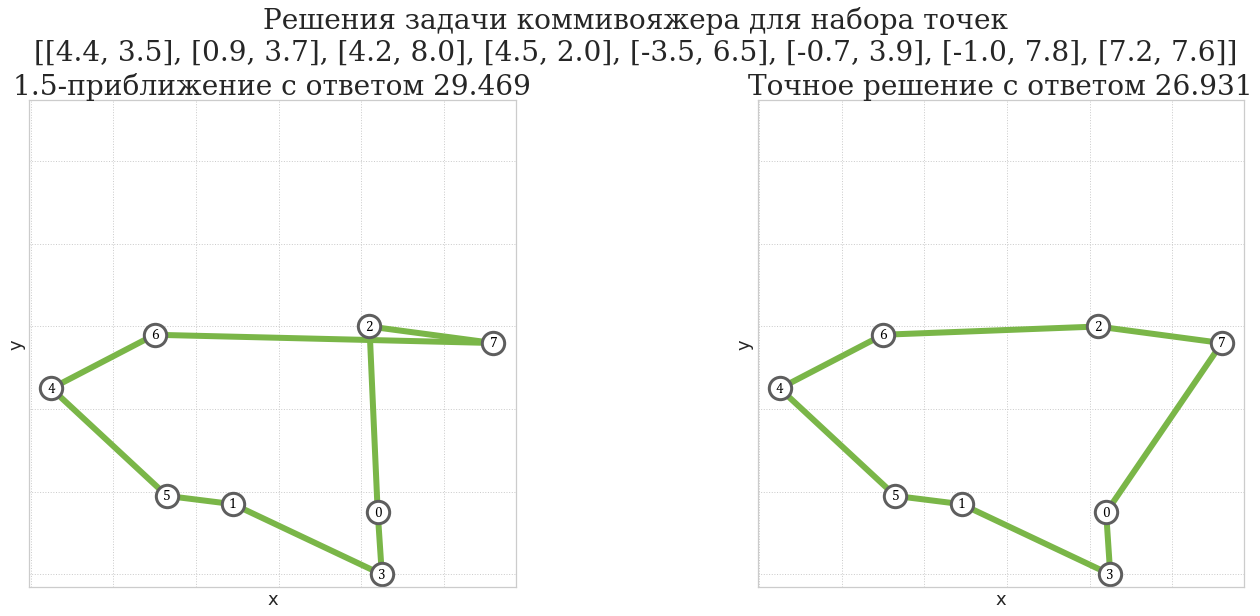

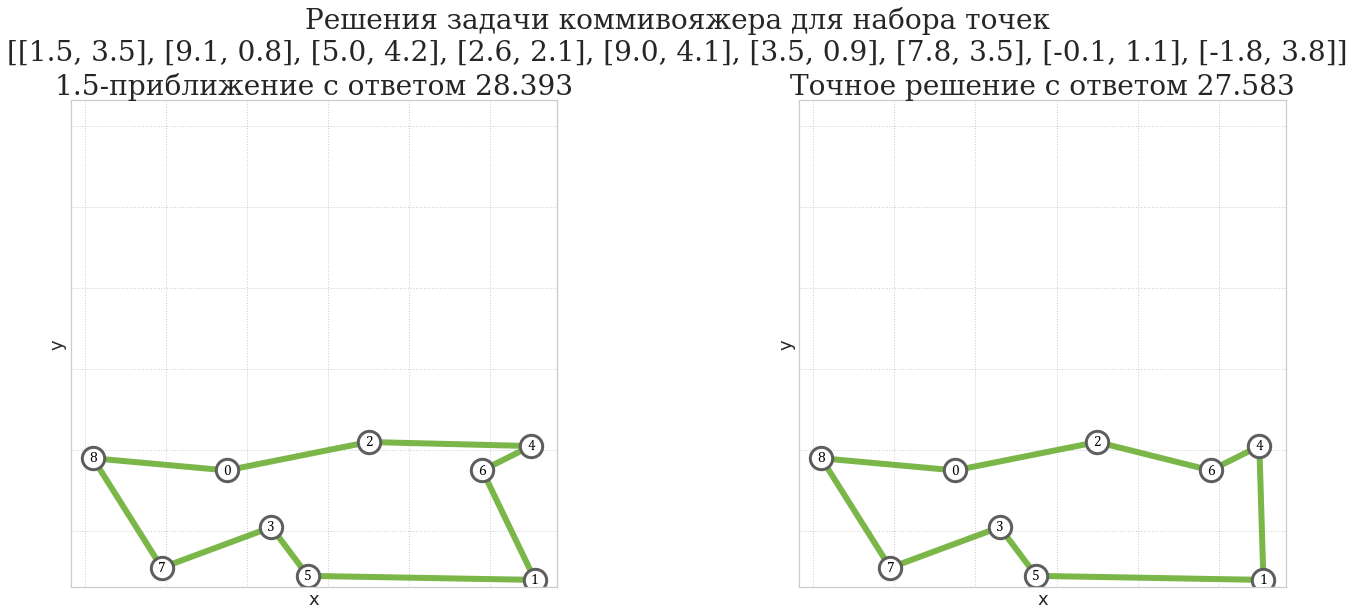

In [2]:
import sys, importlib

if 'support' in sys.modules:
    importlib.reload(sys.modules['support'])
    
from support import find_hamiltonian_path

In [42]:
def get_adjacency_matrix(points, metric='euclidean'):
    '''Для заданного набора точек строит матрицу смежности в соответствии с указанной 
    метрикой
    
    :params:
        - points - набор точек
        - metric - используемая метрика
    '''
    
    points = points[np.newaxis, :]
    diff = points - points.reshape((-1, 1, 2))
    if metric == 'euclidean':
        matrix = np.linalg.norm(diff, axis=-1)
    elif metric == 'manhattan':
        matrix = np.sum(np.abs(diff), axis=-1)
    elif metric == 'max':
        matrix = np.max(np.abs(diff), axis=-1)
    else:
        raise Exception('metric not found')
    
    return matrix

In [43]:
points = np.array([[0, 0],
                  [1, 1],
                  [-1, 2]])

print(get_adjacency_matrix(points, metric='manhattan'))
print(get_adjacency_matrix(points, metric='max'))
# print(get_adjacency_matrix(points, metric='haha'))

[[0 2 3]
 [2 0 3]
 [3 3 0]]
[[0 1 2]
 [1 0 2]
 [2 2 0]]


In [44]:
def get_odd_degree_vertices(graph):
    '''Находит в графе вершины с нечетными степенями
    
    :params:
        - graph - граф, наследник класса nx.Graph
    :return value:
        - vertex_indices - индексы вершин
    '''
    
    vertices, degrees = np.array(graph.degree).T
    return vertices[degrees % 2 == 1]

In [45]:
def find_min_weight_perfect_matching(graph):
    '''Находит в графе максимальное паросочетание минимального веса

    :params:
        - graph - граф, наследник класса nx.Graph
    :return value:
        - matching - ребра паросочетания
    '''
    
    second_graph = nx.Graph()
    for first, second, weight in graph.edges.data('weight'):
        second_graph.add_edge(first, second, weight=-weight)

    return nx.max_weight_matching(second_graph, maxcardinality=True)

In [46]:
def find_hamiltonian_path(points, metric='euclidean'):
    '''Решает 3/2-приближенную метрическую задачу коммивояжера с евклидовой
    метрикой с помощью алгоритма Кристофидеса

    :params:
        - points - координаты вершин в графе
        - metric - используемая метрика
    :return value:
        (vertices, length) - список индексов вершин в гамильтоновом пути
        наименьшего веса и длина этого пути
    '''
    
    adjacency_matrix = get_adjacency_matrix(points, metric)
    graph = nx.from_numpy_array(adjacency_matrix)
    
    minimum_spanning_tree = nx.minimum_spanning_tree(graph)
    
    # print(minimum_spanning_tree.edges(data='weight'))
    
    odd_degree_vertices = get_odd_degree_vertices(minimum_spanning_tree)
    odd_degree_graph = nx.from_numpy_array(
        adjacency_matrix[odd_degree_vertices][:, odd_degree_vertices])
    
    min_weight_perfect_matching = find_min_weight_perfect_matching(
        odd_degree_graph)
    
    # print(min_weight_perfect_matching)
    
    eulerian_graph = nx.MultiGraph()
    for first, second, weight in minimum_spanning_tree.edges(data='weight'):
        eulerian_graph.add_edge(first, second, weight=weight)
    
    for first, second in min_weight_perfect_matching:
        first = odd_degree_vertices[first]
        second = odd_degree_vertices[second]
        eulerian_graph.add_edge(first, second, 
                                weight=adjacency_matrix[first][second])
    
    # print(eulerian_graph.edges(data='weight'))
    
    eulerian_cycle = nx.eulerian_circuit(eulerian_graph)
    
    used = np.zeros(shape=(points.shape[0]))
    length = 0
    result = []
    for v_from, v_to in eulerian_cycle:
        if len(result) == 0:
            result.append(v_from)
            used[v_from] = 1
        if used[v_to] == 0:
            length += adjacency_matrix[result[-1]][v_to]
            result.append(v_to)
            used[v_to] = 1
    length += adjacency_matrix[result[-1]][result[0]]
    
    return result, length

In [47]:
def find_min_weight_hamiltonian_path(points, metric='euclidean'):
    '''Находит точное решение задачи коммивояжёра алгоритмом полного перебора
    
    :params:
        - points - точки на плоскости
        - metric - используемая метрика
        
    :return value:
        - (vertices, length) - список индексов вершин в гамильтоновом пути
        наименьшего веса и длина этого пути
    '''
    
    adjacency_matrix = get_adjacency_matrix(points, metric)
    
    min_length = None
    min_cycle = None
    
    for permutation in permutations(range(len(points))):
        length = 0
        
        for i, first in enumerate(permutation):
            second = permutation[(i + 1) % len(permutation)]
            length += adjacency_matrix[first][second]
        
        if min_length is None or length < min_length:
            min_length = length
            min_cycle = permutation
    
    return min_cycle, min_length

In [48]:
def plot_hamiltonian_path(points, path, length, ax, title, font=None,
                          node_size=500, font_size=14, width=6, linewidths=3,
                          with_labels=True, measured_time=None):
    '''Строит на графике гамильтонов цикл минимального веса для фиксированного 
    набора точек

    :params:
        - points - набор точек на плоскости
        - path - список индексов вершин в гамильтоновом цикле
        - length - длина гамильтонова пути
        - ax - ось
        - title - заголовок
        - font - настройки шрифта, наследник класса FontProperties
        - node_size - размер вершины на графике
        - font_size - размер числа-метки вершины
        - width - ширина ребра
        - linewidths - толщина границы вершины
        - with_labels - нужно ли отображать номера вершин
        - measured_time - время работы алгоритма
    '''

    adjacency_matrix = get_adjacency_matrix(points)

    cycle = nx.Graph()
    for i, first in enumerate(path):
        second = path[(i + 1) % len(path)]
        cycle.add_edge(first, second, weight=adjacency_matrix[first][second])

    with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
        if measured_time is not None:
            title += ' за время {} сек.\n'.format(round(measured_time, 3))
        ax.set_title(title + ' с ответом {}'.format(length.round(3)),
                     fontsize=28, fontproperties=font)

        nx.draw_networkx(cycle, pos=points, node_color='white', ax=ax,
                         edgecolors='#5E5E5E', linewidths=linewidths,
                         edge_color='#7AB648', font_family='Cambria',
                         node_size=node_size, font_size=font_size, width=width,
                         with_labels=with_labels)

        ax.set_xlabel('x', fontsize=18)
        ax.set_ylabel('y', fontsize=18)
        ax.grid(ls=':', b=True)

In [49]:
def compare_solutions(points, metric='euclidean', filename=None):
    '''Рисует на графике 1.5-приближение решения задачи коммивояжера и точное решение

    :params:
        - points - набор точек
        - metric - используемая метрика
        - filename - имя файла для сохранения графика
    '''

    correct_path, correct_length = find_min_weight_hamiltonian_path(
        points, metric)
    path, length = find_hamiltonian_path(points, metric)

    with sns.plotting_context('notebook'), sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(20.7, 8.9))

        font = FontProperties(family='serif', size=28)

        fig.suptitle('Решения задачи коммивояжера для набора точек\n'
                     '{}'.format(points.tolist()), y=0.97,
                     fontproperties=font)

        ax_left = plt.subplot(1, 2, 1, sharex=plt.gca(), sharey=plt.gca())
        ax_left.axis('square')

        plot_hamiltonian_path(points, path, length, ax_left, '1.5-приближение',
                              font)

        ax_right = plt.subplot(1, 2, 2, sharex=plt.gca(), sharey=plt.gca())
        ax_right.axis('square')

        plot_hamiltonian_path(points, correct_path, correct_length, ax_right,
                              'Точное решение', font)

        fig.tight_layout(rect=[0, 0.01, 1, 1])

        if filename is not None:
            fig.savefig(filename, transparent=True)

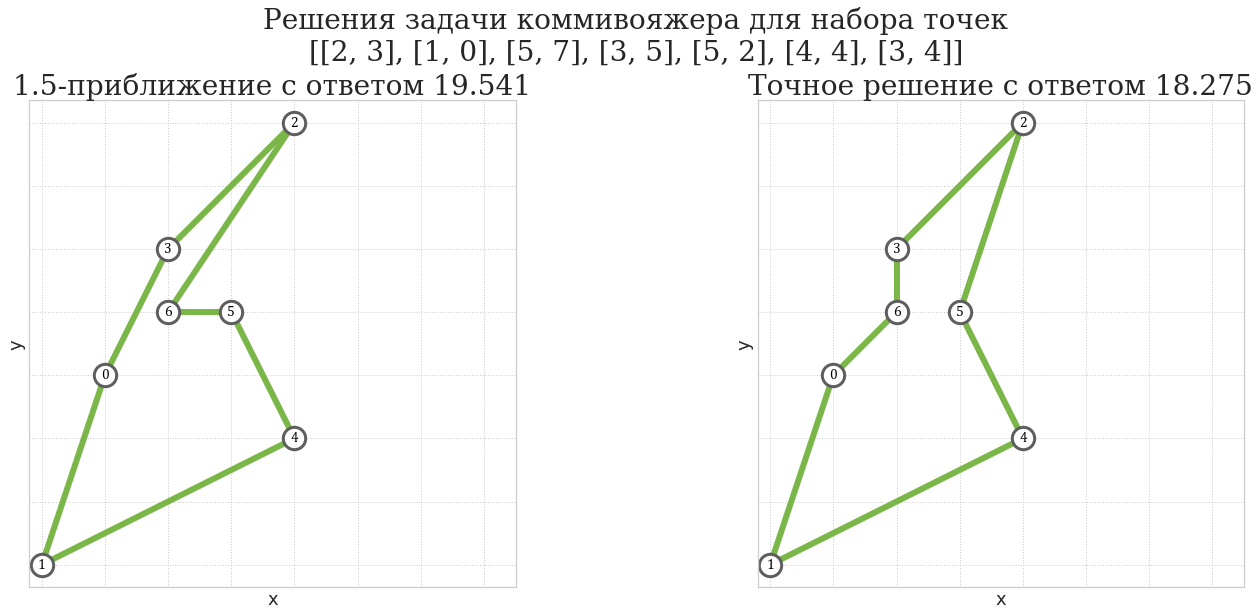

In [56]:
points = np.array([[2, 3],
                   [1, 0],
                   [5, 7],
                   [3, 5],
                   [5, 2],
                   [4, 4],
                   [3, 4]])

compare_solutions(points, filename='test.png')

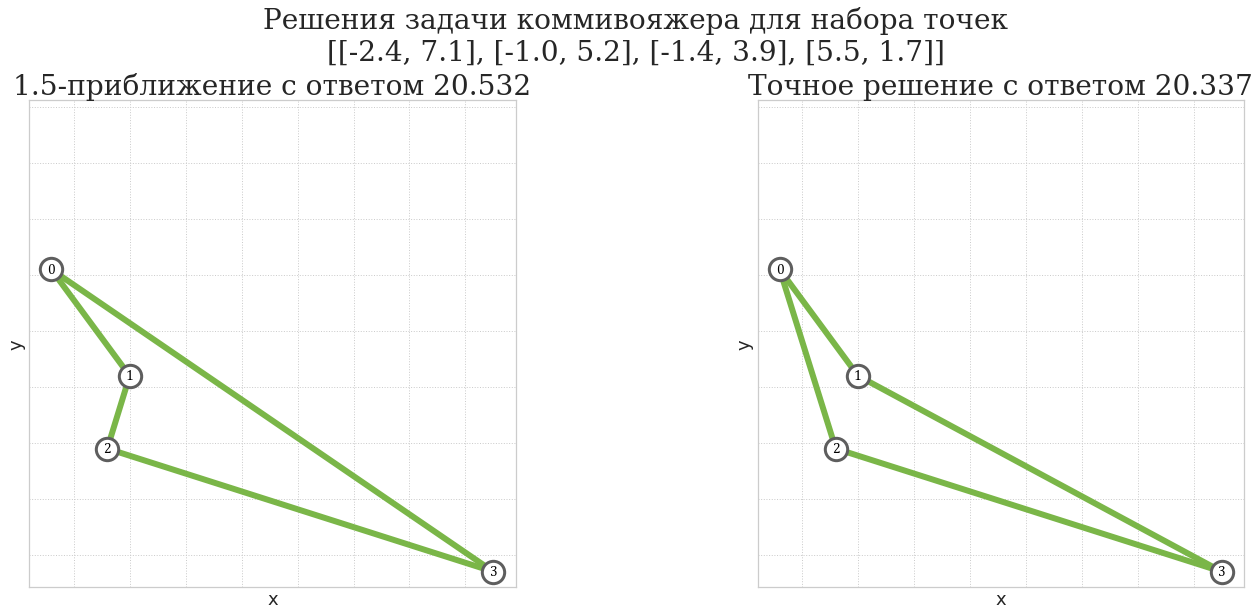

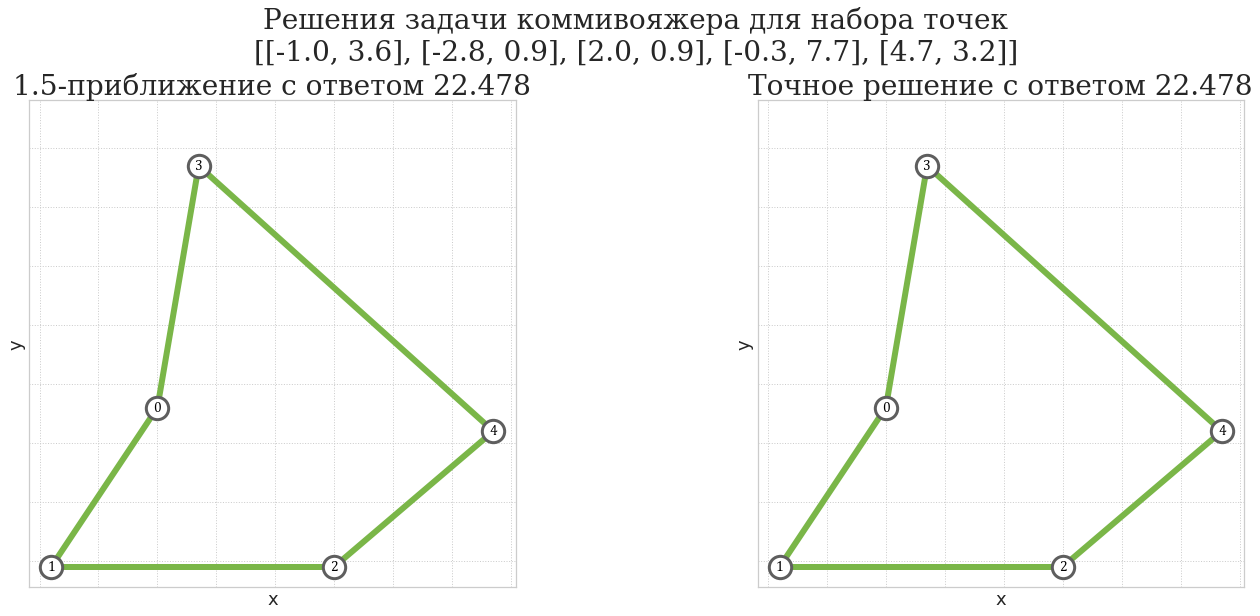

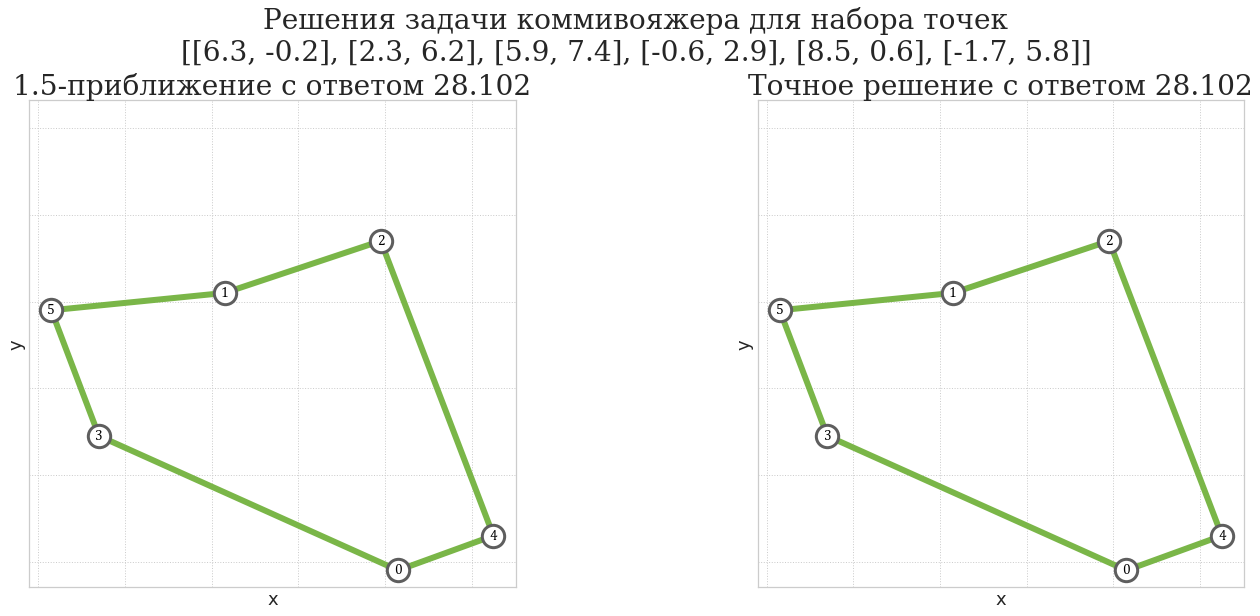

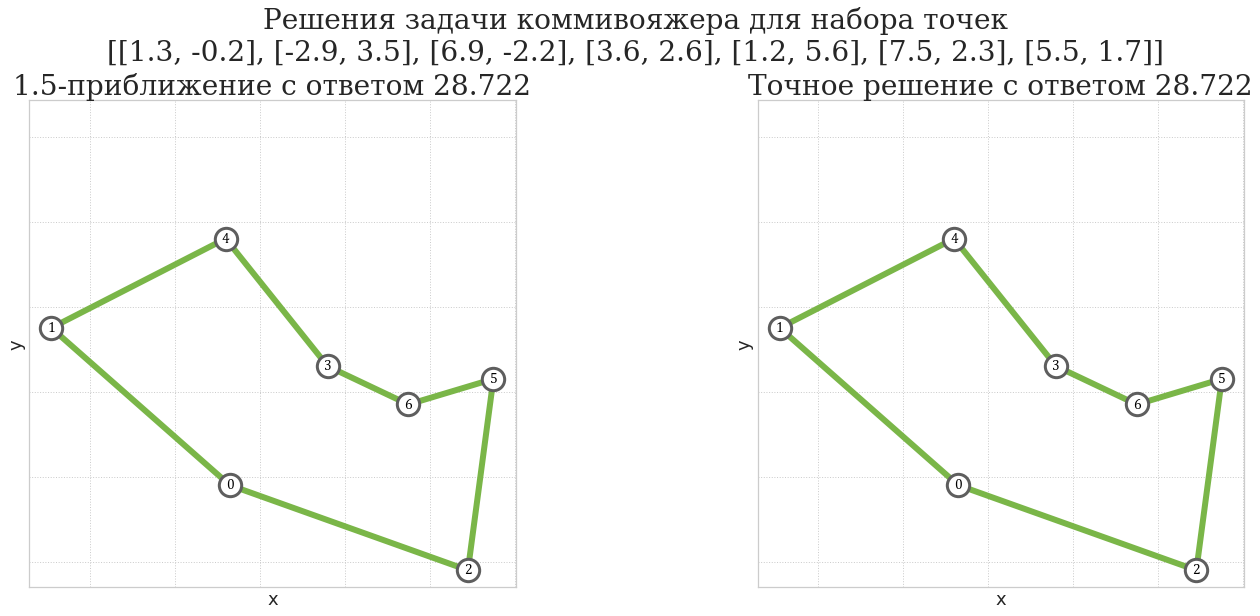

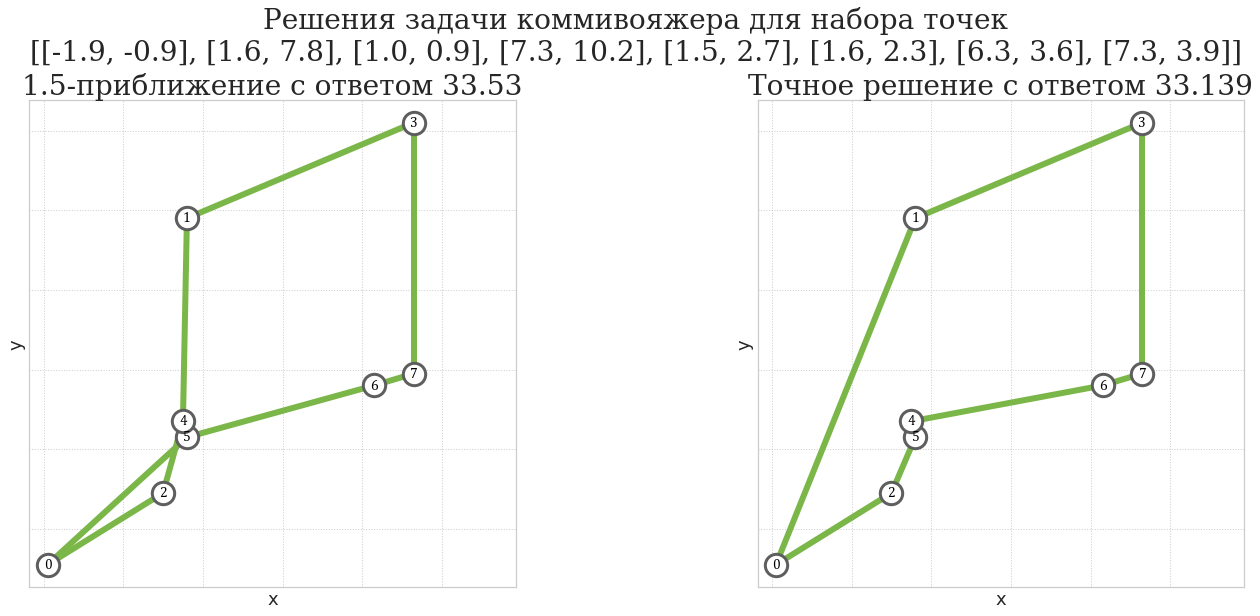

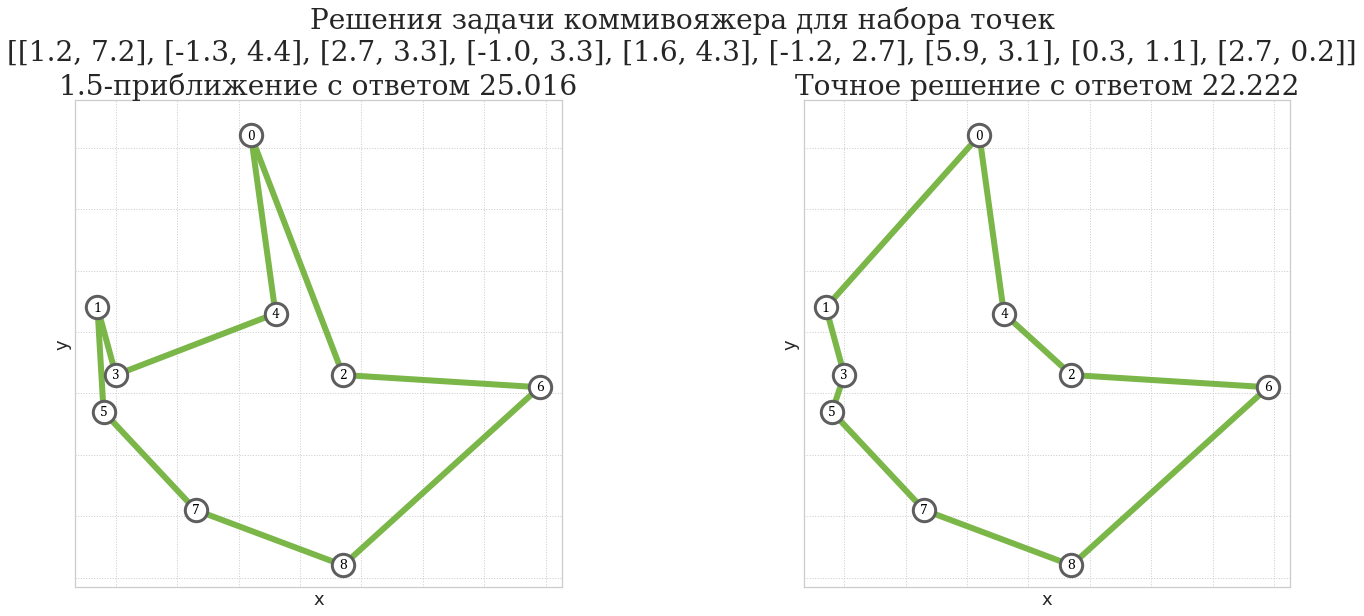

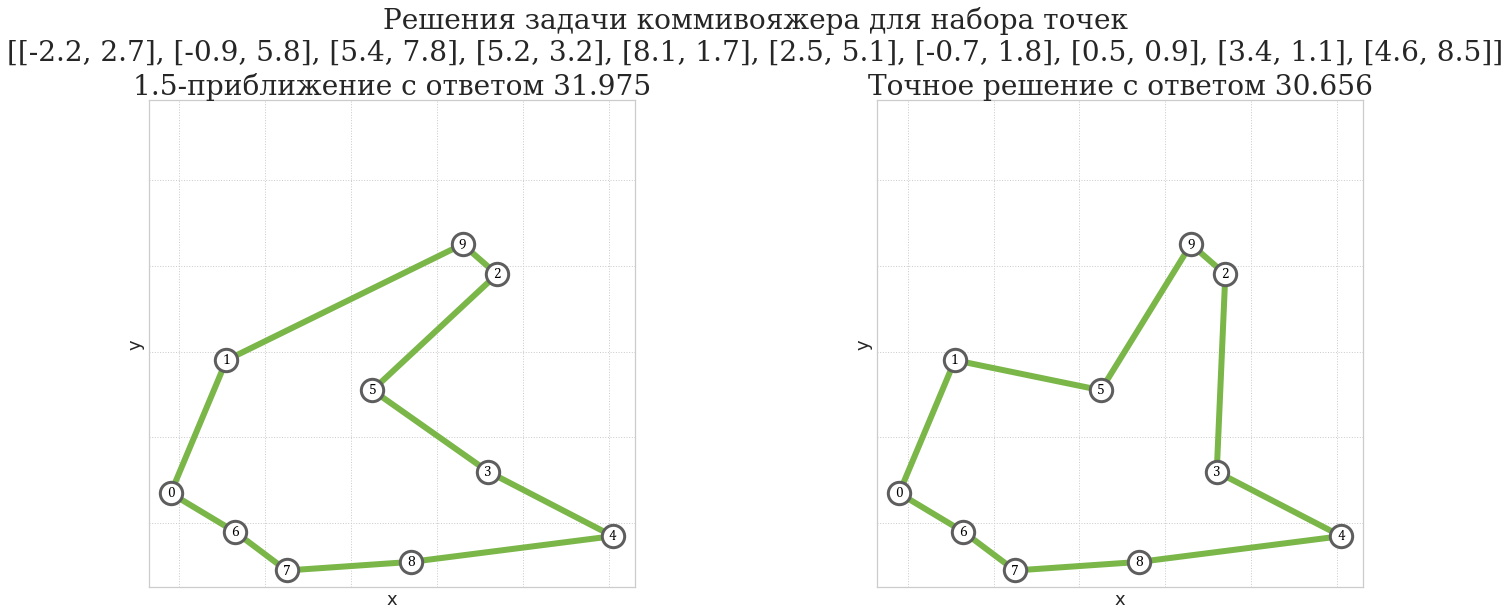

In [55]:
mean = np.array([3, 3])
cov = np.array([[10, 0],
                [0, 10]])

lower_bound = 4
upper_bound = 11

for i, sample_size in enumerate(tqdm(np.arange(lower_bound, upper_bound))):
    sample = sps.multivariate_normal(mean, cov).rvs(size=sample_size).round(1)
    compare_solutions(sample, filename='small{}.png'.format(i+1))

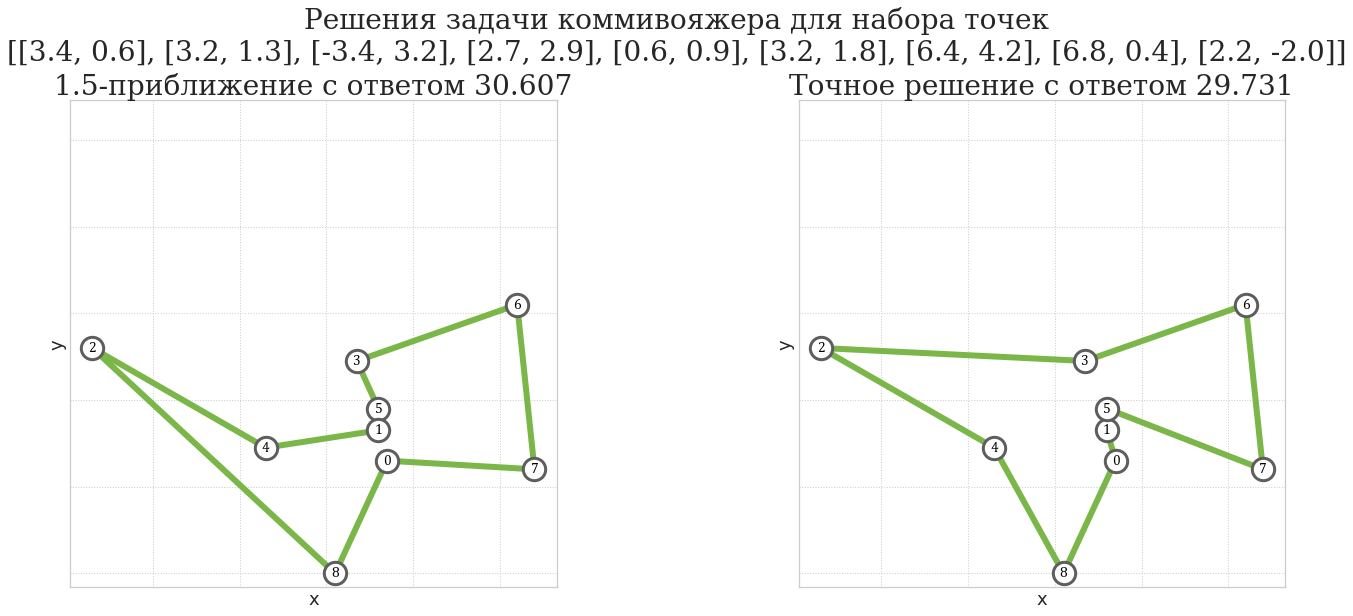

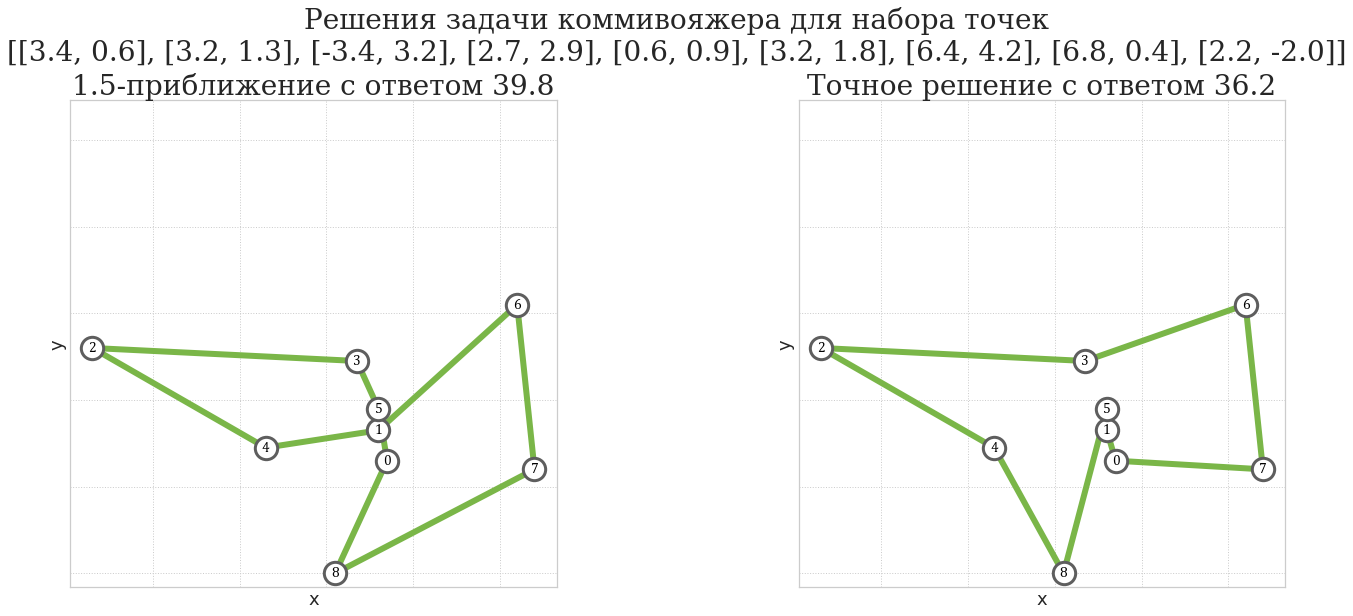

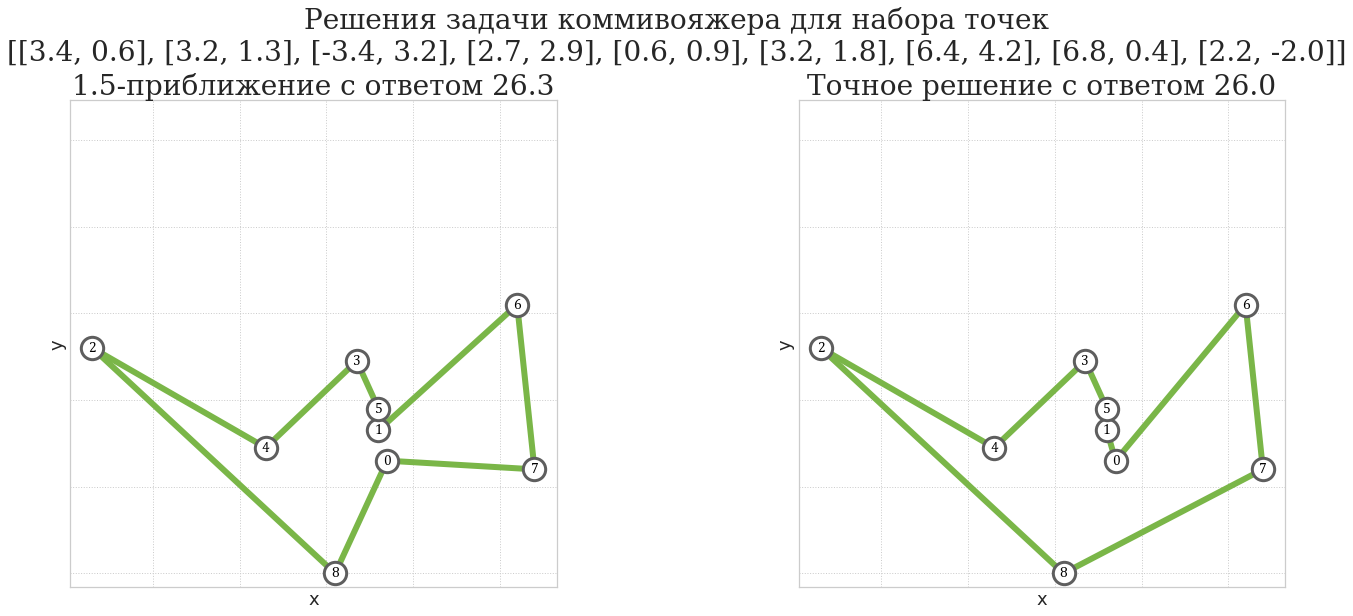

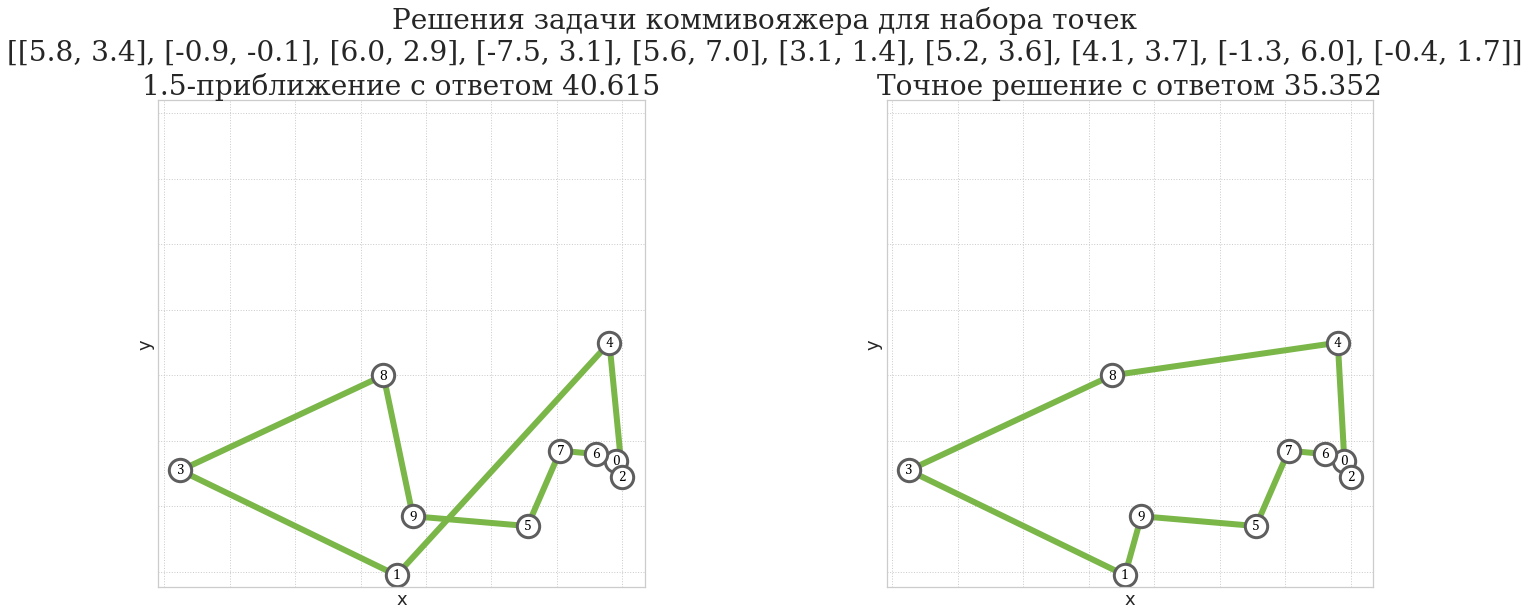

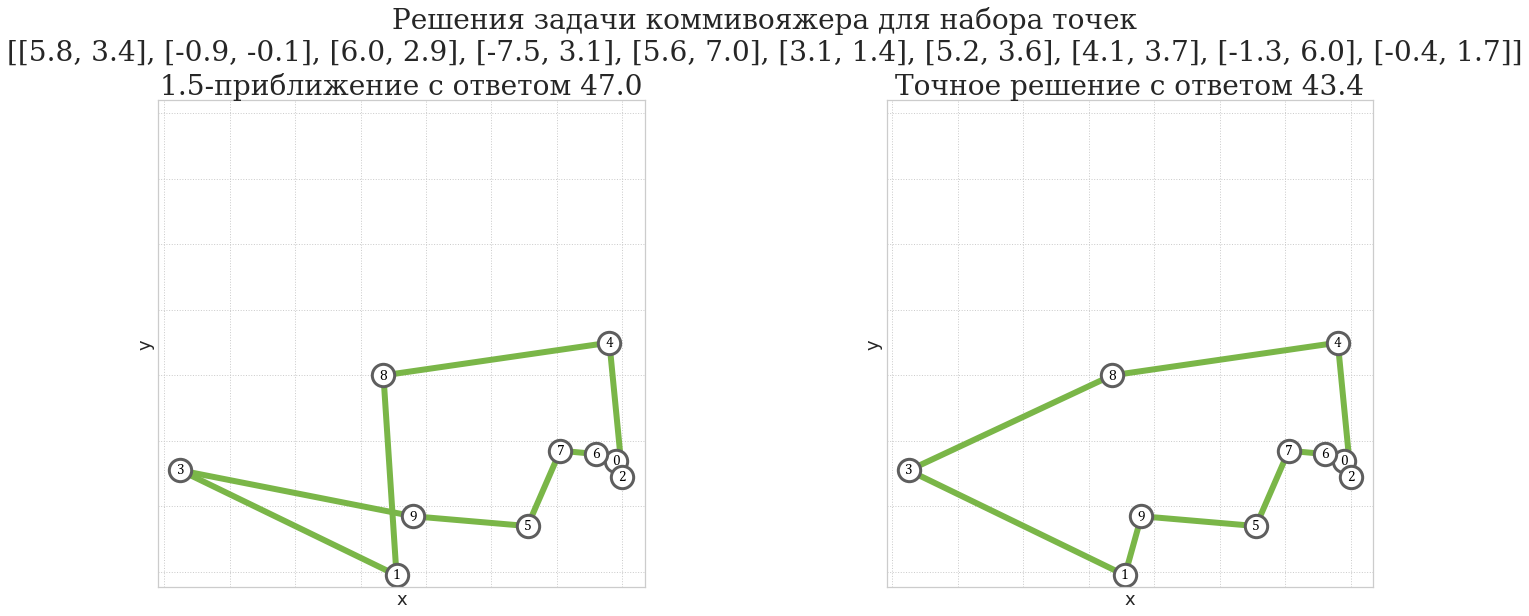

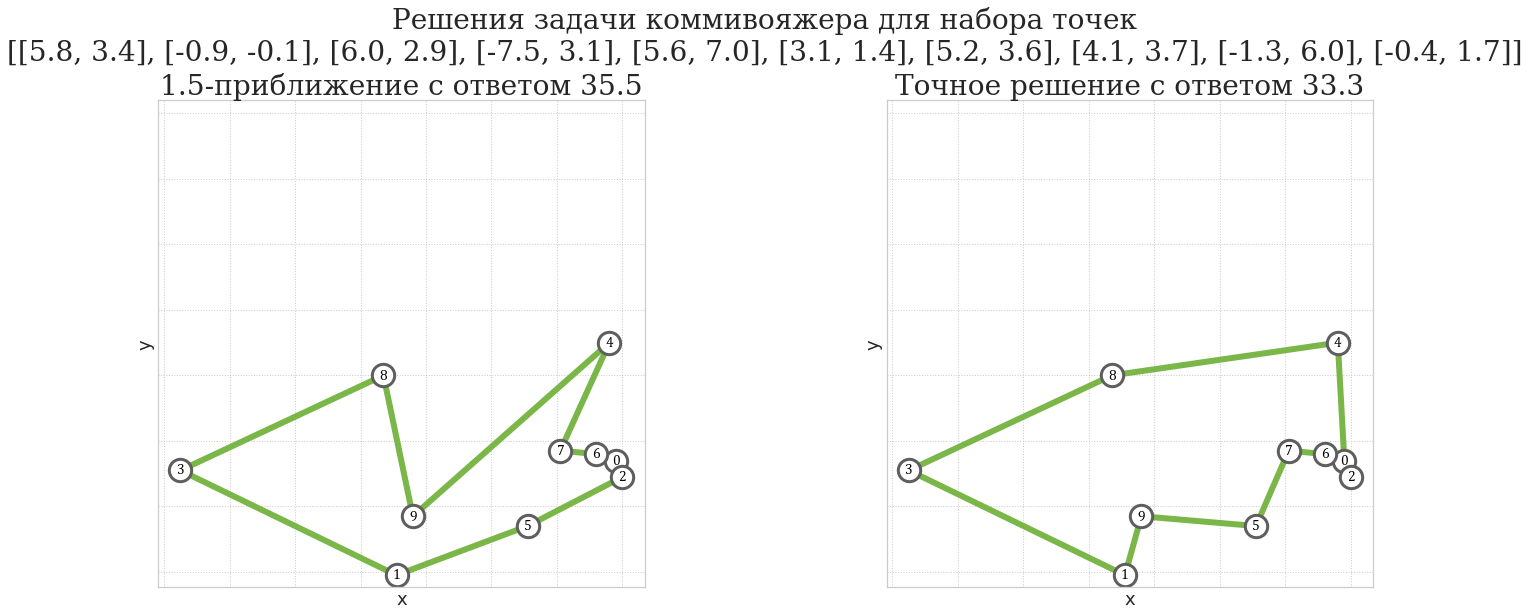

In [62]:
lower_bound = 9
upper_bound = 11

for i, sample_size in enumerate(tqdm(np.arange(lower_bound, upper_bound))):
    sample = sps.multivariate_normal(mean, cov).rvs(size=sample_size).round(1)
    compare_solutions(sample, metric='euclidean',
                      filename='eu_metric{}.png'.format(i + 1))
    compare_solutions(sample, metric='manhattan',
                      filename='ma_metric{}.png'.format(i + 1))
    compare_solutions(sample, metric='max',
                      filename='max_metric{}.png'.format(i + 1))

In [20]:
mean = np.array([3, 3])
cov = np.array([[100, 0],
                [0, 100]])

num_points = np.arange(4, 12)
time_correct = np.array([])
time_approx = np.array([])

for sample_size in tqdm(num_points):
    sample = sps.multivariate_normal(mean, cov).rvs(size=sample_size).round(1)
    
    start = time.time()
    path, length = find_hamiltonian_path(sample)
    time_approx = np.append(time_approx, time.time() - start)
    
    start = time.time()
    path_correct, path_length = find_min_weight_hamiltonian_path(sample)
    time_correct = np.append(time_correct, time.time() - start)

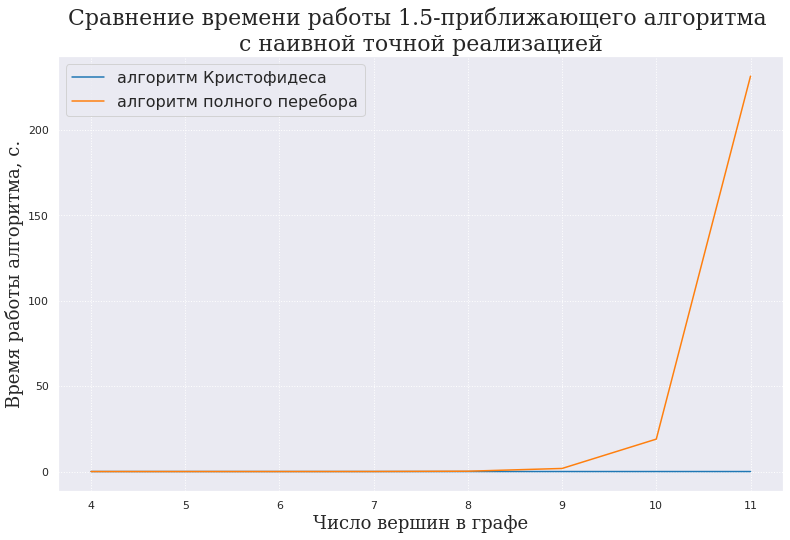

In [688]:
with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
    plt.figure(figsize=(13, 8))
    
    font = FontProperties(family='serif', size=28)
    
    plt.title('Сравнение времени работы 1.5-приближающего алгоритма \n'
              'с наивной точной реализацией', fontsize=22, fontproperties=font)

    plt.plot(num_points, time_approx, label='алгоритм Кристофидеса')

    plt.plot(num_points, time_correct, label='алгоритм полного перебора')

    plt.xlabel('Число вершин в графе', fontsize=18, fontproperties=font)
    plt.ylabel('Время работы алгоритма, с.', fontsize=18, fontproperties=font)
    plt.legend(fontsize=16)
    plt.grid(ls=':', b=True)
    plt.savefig('speed1.png')

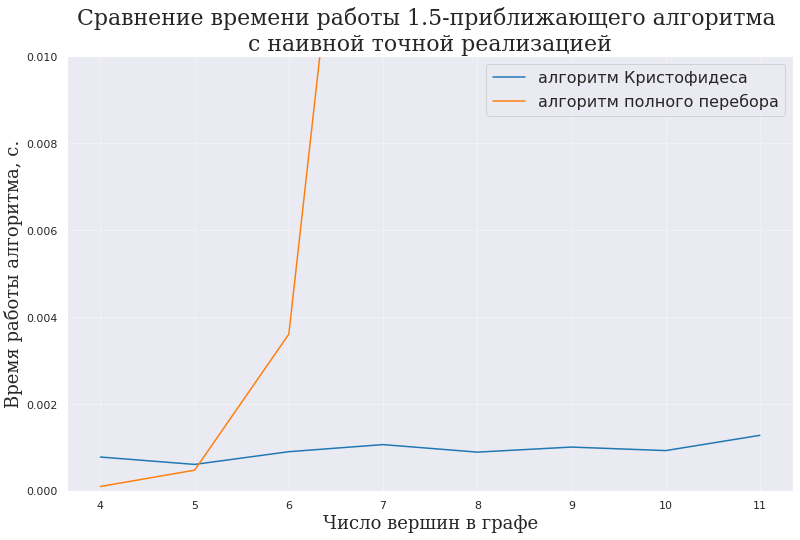

In [692]:
num_points = np.ones_like(time_approx).cumsum() + 3

with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
    plt.figure(figsize=(13, 8))
    
    font = FontProperties(family='serif', size=28)
    
    plt.title('Сравнение времени работы 1.5-приближающего алгоритма \n'
              'с наивной точной реализацией', fontsize=22, fontproperties=font)

    plt.plot(num_points, time_approx, label='алгоритм Кристофидеса')

    plt.plot(num_points, time_correct, label='алгоритм полного перебора')

    plt.ylim((0, 0.01))
    plt.xlabel('Число вершин в графе', fontsize=18, fontproperties=font)
    plt.ylabel('Время работы алгоритма, с.', fontsize=18, fontproperties=font)
    plt.legend(fontsize=16)
    plt.grid(ls=':', b=True)
    plt.savefig('speed2.png')

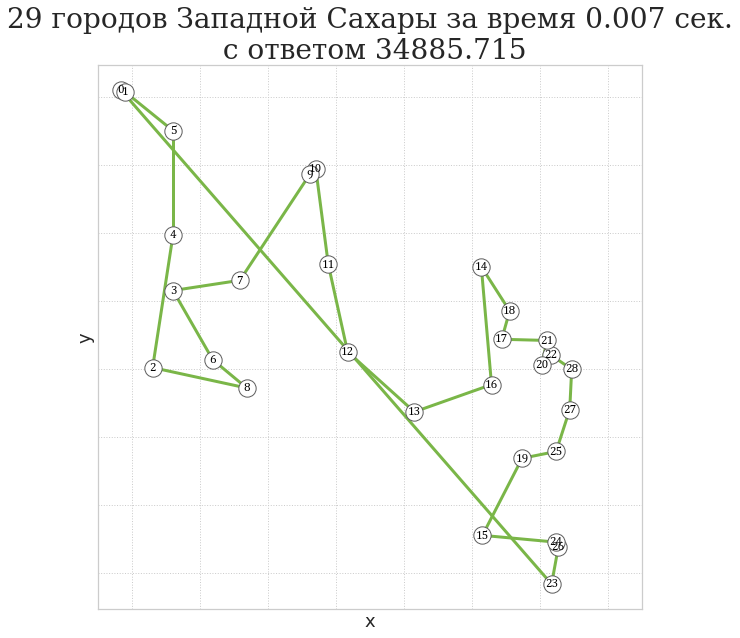

In [743]:
cities = pd.read_csv('./data/wi29.tsp', sep=' ', skiprows=8, 
                     names=['id', 'x', 'y'], skipfooter=1, engine='python', index_col='id')
    
points = cities.to_numpy()

start = time.time()
path, length = find_hamiltonian_path(points)
measured_time = time.time() - start

with sns.plotting_context('notebook'), sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(10, 10))
    
    font = FontProperties(family='serif', size=28)
    
    plot_hamiltonian_path(points, path, length, ax=plt.gca(), 
                          title='29 городов Западной Сахары', font=font, node_size=300, 
                          font_size=12, width=3, linewidths=1,
                          measured_time=measured_time)
    plt.axis('square')
    
    fig.savefig('29cities.png', transparent=True)

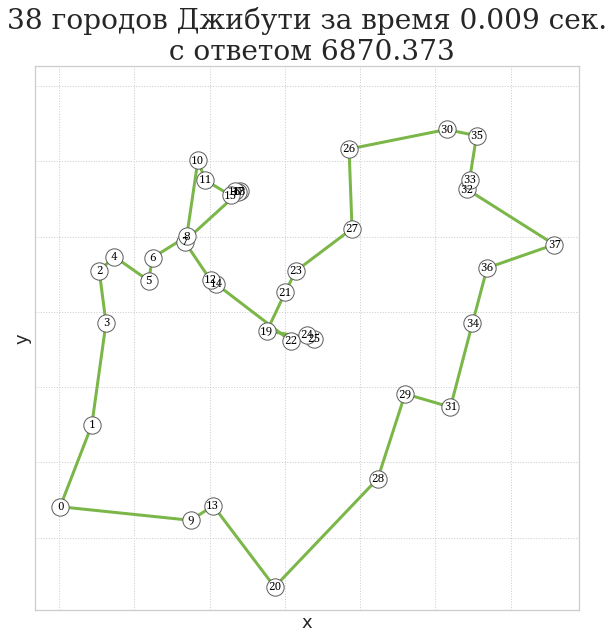

In [735]:
cities = pd.read_csv('./data/dj38.tsp', sep=' ', skiprows=8, 
                     names=['id', 'x', 'y'], skipfooter=1, engine='python', index_col='id')
    
points = cities.to_numpy()

start = time.time()
path, length = find_hamiltonian_path(points)
measured_time = time.time() - start

with sns.plotting_context('notebook'), sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(10, 10))
    
    font = FontProperties(family='serif', size=28)
    
    plot_hamiltonian_path(points, path, length, ax=plt.gca(), 
                          title='38 городов Джибути', font=font, node_size=300, 
                          font_size=12, width=3, linewidths=1, 
                          measured_time=measured_time)
    plt.axis('square')
    
    fig.savefig('38cities.png', transparent=True)

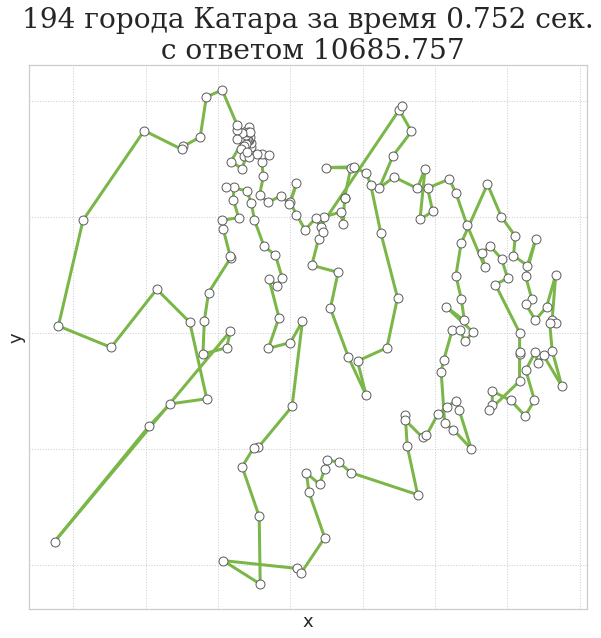

In [746]:
cities = pd.read_csv('./data/qa194.tsp', sep=' ', skiprows=8, 
                     names=['id', 'x', 'y'], skipfooter=1, engine='python', index_col='id')
    
points = cities.to_numpy()

start = time.time()
path, length = find_hamiltonian_path(points)
measured_time = time.time() - start

with sns.plotting_context('notebook'), sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(10, 10))
    
    font = FontProperties(family='serif', size=28)
    
    plot_hamiltonian_path(points, path, length, ax=plt.gca(), 
                          title='194 города Катара', font=font, node_size=80, 
                          font_size=10, width=3, linewidths=1,
                          with_labels=False, measured_time=measured_time)
    
    fig.savefig('194cities.png', transparent=True)

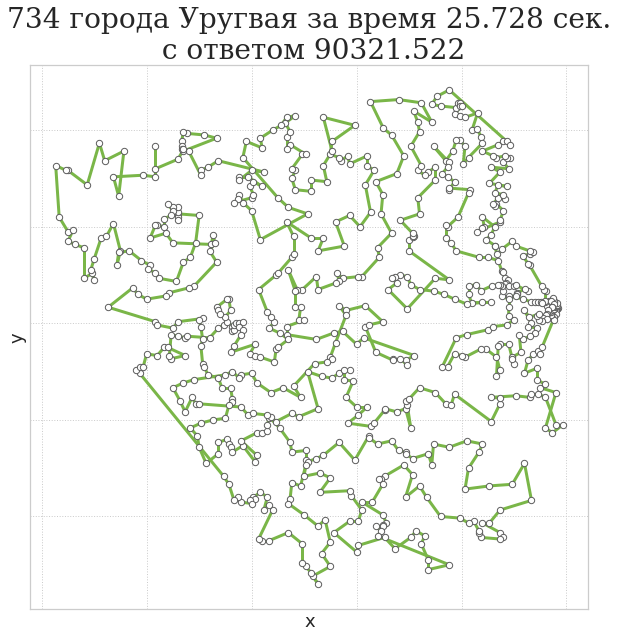

In [749]:
cities = pd.read_csv('./data/uy734.tsp', sep=' ', skiprows=8, 
                     names=['id', 'x', 'y'], skipfooter=1, engine='python', index_col='id')
    
points = cities.to_numpy()

start = time.time()
path, length = find_hamiltonian_path(points)
measured_time = time.time() - start

with sns.plotting_context('notebook'), sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(10, 10))
    
    font = FontProperties(family='serif', size=28)
    
    plot_hamiltonian_path(points, path, length, ax=plt.gca(), 
                          title='734 города Уругвая', font=font, node_size=40, 
                          font_size=8, width=3, linewidths=1,
                          with_labels=False, measured_time=measured_time)
    
    fig.savefig('734cities.png', transparent=True)

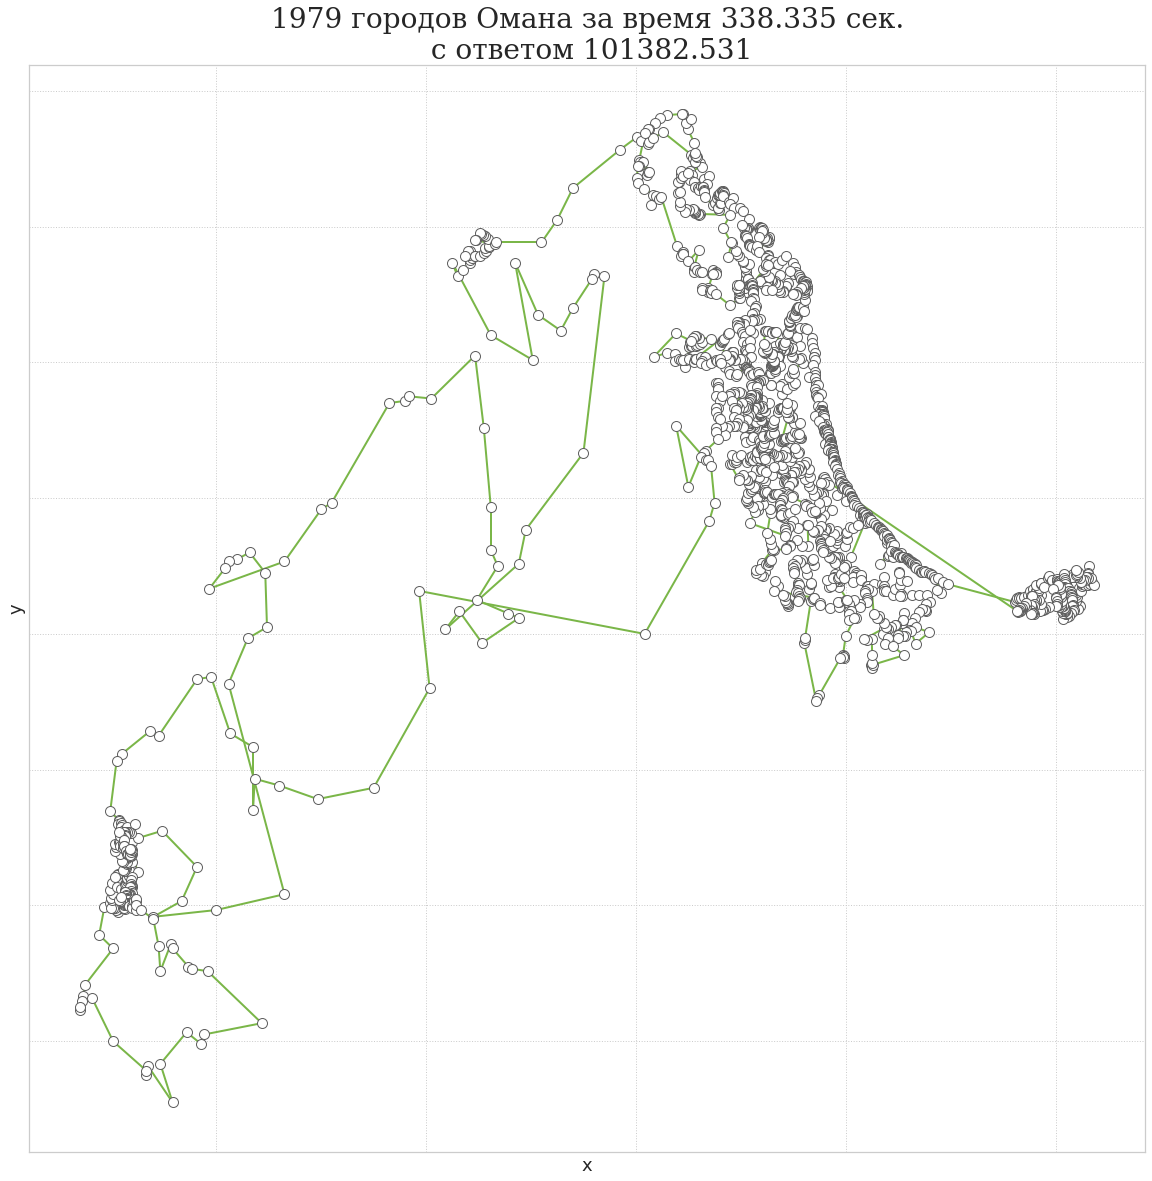

In [748]:
cities = pd.read_csv('./data/mu1979.tsp', sep=' ', skiprows=8, 
                     names=['id', 'x', 'y'], skipfooter=1, engine='python', index_col='id')
    
points = cities.to_numpy()

start = time.time()
path, length = find_hamiltonian_path(points)
measured_time = time.time() - start

with sns.plotting_context('notebook'), sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(20, 20))
    
    font = FontProperties(family='serif', size=28)
    
    plot_hamiltonian_path(points, path, length, ax=plt.gca(), 
                          title='1979 городов Омана', font=font, node_size=100, 
                          font_size=8, width=2, linewidths=1,
                          with_labels=False, measured_time=measured_time)
    
    fig.savefig('1979cities.png', transparent=True)

In [662]:
filenames = glob('./data/*.tsp')

num_points = np.array([])
deviation = np.array([]) 

for filename in tqdm(filenames):
    cities = pd.read_csv(filename, sep=' ', skiprows=8, 
                     names=['id', 'x', 'y'], skipfooter=1, engine='python', index_col='id')
    with open(filename, 'r') as file:
        correct_length = float(file.readline())
    
    points = cities.to_numpy()
    path, length = find_hamiltonian_path(points)
    
    num_points = np.append(num_points, points.shape[0])
    deviation = np.append(deviation, (length - correct_length) / correct_length)

In [665]:
data = np.vstack((num_points, deviation))
data = np.array(sorted(data.T.tolist(), key=lambda x: x[0]))
num_points1, deviation1 = np.hsplit(data, 2)
num_points1 = np.ravel(num_points1)
deviation1 = np.ravel(deviation1)
print(num_points1, deviation1)

[  29.   38.  194.  734.  980. 1621. 1979.] [0.26383781 0.03220755 0.14261725 0.14166294 0.69731346 0.88925606
 0.16677827]


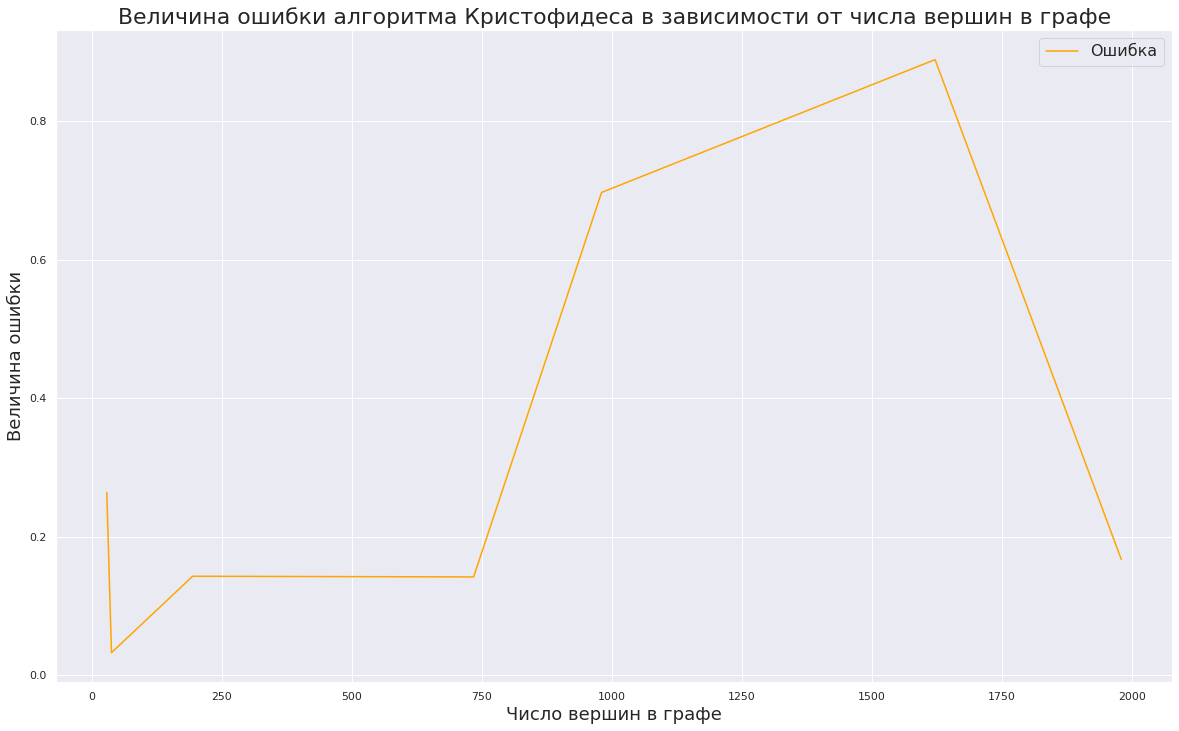

In [666]:
with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
    plt.figure(figsize=(20, 12))
    plt.title('Величина ошибки алгоритма Кристофидеса в зависимости от числа вершин'
              ' в графе', fontsize=22)
    
    plt.plot(num_points1, deviation1, label='Ошибка', color='orange')
    
    plt.xlabel('Число вершин в графе', fontsize=18)
    plt.ylabel('Величина ошибки', fontsize=18)
    plt.legend(fontsize=16)